##  Classification pipeline

### Last update: 9/9/19
### File: C:\Users\megan\OneDrive\Data_Analytics\C5T2_3\Credit-default-analysis
### Project Name: Credit Default Analysis

In [2]:
#Import libraries and modules

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from scipy import stats

# visualization
import seaborn as sns
from matplotlib import pyplot as plt
import plotly
import plotly.tools as tls
%matplotlib inline

# machine learning
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
#from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix
from sklearn.neural_network import MLPClassifier
#from sklearn.model_selection import GridSearchCV
import dask_ml.model_selection as dcv

pd.options.display.max_columns = 30

In [3]:
#import data

#load train/existing data (dataset1)
credit = pd.read_csv('default of credit card clients.csv', header = 1)

#load predict/new data (dataset2)

FileNotFoundError: [Errno 2] File b'default of credit card clients.csv' does not exist: b'default of credit card clients.csv'

### Data Pre-Processing

In [ ]:
#check for missing data
print(credit.isnull().values.any())

In [ ]:
credit.head()

In [ ]:
credit.describe()

In [ ]:
credit.columns

In [ ]:
credit['SEX'].value_counts()

In [ ]:
18112 / 30000

In [ ]:
11888 / 30000

In [ ]:
credit['default payment next month'].value_counts()

In [ ]:
23364 / 30000

About 78% percent of the population is no for default; About 22% is yes for default

In [ ]:
credit.info()

All variables are listed as integers in dataset. Need to change sex, education, and marriage to category after exploratory data analysis is done.

In [ ]:
credit = credit.drop(columns=['ID'])

In [ ]:
credit.rename(columns={"default payment next month": "default"}, inplace = True)

In [ ]:
credit.head()

In [ ]:
credit['EDUCATION'].value_counts()

In [ ]:
#group education levels 4,5,6 into single group 4 
#NOTE for future analysis, it would help to understand what 4,5,6 are
credit['EDUCATION'] = credit['EDUCATION'].replace([4, 5, 6], 4)

In [ ]:
#check recode
credit['EDUCATION'].value_counts()

In [ ]:
#check negative amounts for bill statements to see if they make sense
credit.nsmallest(10, 'BILL_AMT6')

In [ ]:
#check outliers - done with EDA below

In [ ]:
#several rows with 0's across payment amt and bill amt. check how many
zero = (credit[(credit.PAY_AMT1 == 0) & (credit.PAY_AMT2 == 0) & (credit.PAY_AMT3 == 0) & (credit.PAY_AMT4 == 0) & \
             (credit.PAY_AMT5 == 0) & (credit.PAY_AMT6 == 0) & (credit.BILL_AMT1 ==0) & (credit.BILL_AMT2 ==0) & \
                   (credit.BILL_AMT3 == 0) & (credit.BILL_AMT4 == 0) & (credit.BILL_AMT5 == 0) & (credit.BILL_AMT6 == 0)])

In [ ]:
print(zero.count())

There are a total of 795 rows where BOTH the bill amount and payment amount are zero. Assuming these are 0 balances with no usage.

### Exploratory Data Analysis

In [ ]:
sns.set(style="darkgrid")

In [ ]:
header = credit.dtypes.index
print(header)

In [ ]:
#visualize distributions
plt.hist(credit['LIMIT_BAL'])
plt.show()

In [ ]:
credit['SEX'].value_counts()

In [ ]:
fg = sns.catplot('SEX', data=credit, kind='count', aspect=1.5)
fg.set_xlabels('SEX')

There are 1.5 more females in this dataset than males.

In [ ]:
g = sns.catplot('EDUCATION', data=credit, kind='count', aspect=1)
g.set_xlabels('EDUCATION')

There are only 14 people in the '0' education category. The others are grouped into category 4, which is still small compared to the others.

In [ ]:
sns.catplot('MARRIAGE', data=credit, kind='count', aspect=1)

Vast majority of customers are either married (1) or single (2).

In [ ]:
# Number of men and women in each of the education levels
credit.groupby(['SEX', 'EDUCATION'])['SEX'].count()

In [ ]:
sns.catplot('EDUCATION', data=credit, hue='SEX', kind='count', aspect=1.5)

Distribution seems to fit the 1.5x females versus males. Females are higher in every education level and they trend similarly.

In [ ]:
# Number of men and women in each of the education levels
credit.groupby(['EDUCATION', 'MARRIAGE'])['EDUCATION'].count()

In [ ]:
sns.catplot('MARRIAGE', data=credit, hue='EDUCATION', kind='count', aspect=1.5)

There are approx the same number of married (2) and single (1) people with university (2) education. There are much less married (2) people with graduate school (1) compared to single people.

In [ ]:
sns.catplot('MARRIAGE', data=credit, hue='SEX', kind='count', aspect=1.5)

In [ ]:
#distribution of age by marriage
fig = sns.FacetGrid(credit, hue='MARRIAGE', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Marriage')
fig.add_legend()

As expected, the majority of the single (2) customers are also the youngest.

In [ ]:
#distribution of age by education
fig2 = sns.FacetGrid(credit, hue='EDUCATION', aspect=4)
fig2.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig2.set(xlim=(0,oldest))
fig2.set(title='Distribution of Age Grouped by Education Level')
fig2.add_legend()

Also interesting that those with graduate schooling (1) also tend to be younger. More younger people have university (2)education vs the older population tend to have just high school (3) level.

In [ ]:
plt.hist(credit['PAY_0'])
plt.show()

There appear to be outliers in this group at the 7 month mark. Let's look closer at the actual values.

In [ ]:
credit['PAY_0'].value_counts()

In [ ]:
A = credit['PAY_0']
plt.boxplot(A,0,'gD')
plt.show()

Technically there are outlier values, but because they range from 2-8 and there is a significant number of them, they will not be removed. Logically, one would think delaying payment would be a significant factor on default risk.

In [ ]:
# Review if sex relates to payment delays
credit.groupby(['PAY_0', 'SEX'])['PAY_0'].count()

In [ ]:
sns.catplot('PAY_0', data=credit, hue='SEX', kind='count', aspect=1.5)

In [ ]:
sns.catplot('PAY_0', data=credit, hue='EDUCATION', kind='count', aspect=1.5)

In [ ]:
sns.catplot('PAY_0', data=credit, hue='MARRIAGE', kind='count', aspect=1.5)

In [ ]:
plt.hist(credit['PAY_2'])
plt.show()

In [ ]:
credit['PAY_2'].value_counts()

In [ ]:
plt.hist(credit['PAY_3'])
plt.show()

In [ ]:
credit['PAY_3'].value_counts()

In [ ]:
plt.hist(credit['PAY_4'])
plt.show()

In [ ]:
credit['PAY_4'].value_counts()

In [ ]:
plt.hist(credit['PAY_5'])
plt.show()

In [ ]:
credit['PAY_5'].value_counts()

In [ ]:
plt.hist(credit['PAY_6'])
plt.show()

In [ ]:
credit['PAY_6'].value_counts()

All of the payment columns show a highly left-skewed distribution, with 0 (no delay) being dominating group every time. Depending on model used will need to normalize later.

In [ ]:
plt.hist(credit['BILL_AMT1'],4)
print(credit.BILL_AMT1.min())
print(credit.BILL_AMT1.max())

In [ ]:
#who had the lowest bill?
credit[credit.BILL_AMT1 == -165580]

For first month tracked, a 37 year old, college educated, married male had the lowest bill (as a credit)

In [ ]:
#who had the highest bill?
credit[credit.BILL_AMT1 == 964511]

For the first month tracked, a 47 year old, graduate school, married female had the highest bill.

In [ ]:
plt.hist(credit['BILL_AMT6'],4)
print(credit.BILL_AMT6.min())
print(credit.BILL_AMT6.max())

In [ ]:
#are the same people the min/max for the sixth month?
credit[(credit.BILL_AMT6 == -339603) | (credit.BILL_AMT6 == 961664)]

The person with the highest bill is the same. New person for lowest bill (33 y/o single male).<br>
Interesting to note that person with lowest bill defaults, person with highest bill does not.

In [ ]:
plt.hist(credit['PAY_AMT1'],6)
print(credit.PAY_AMT1.min())
print(credit.PAY_AMT1.max())

In [ ]:
plt.hist(credit['PAY_AMT6'],6)
print(credit.PAY_AMT6.min())
print(credit.PAY_AMT6.max())

In [ ]:
#calculate ratio of last bill amount to limit balance
ratio = credit.PAY_AMT6 / credit.LIMIT_BAL

In [ ]:
plt.hist(ratio)
plt.show()

In [ ]:
plt.hist(credit['default'])
plt.show()

In [ ]:
# Linear plot of age vs. default rate
sns.lmplot('AGE', 'default', data=credit)

Not a large difference by age, although the older you are the very slightly higher chance that you'll default.

In [ ]:
# default vs. Age grouped by Sex
sns.lmplot('AGE', 'default', data=credit, col='SEX')

In [ ]:
# default vs. sex
sns.countplot(x="SEX", hue="default", data=credit)

In [ ]:
# default vs. Age grouped by Sex
sns.countplot('EDUCATION', hue='default', data=credit)

In [ ]:
credit.groupby(['EDUCATION', 'default'])['EDUCATION'].count()

Education level 3 has the highest proportion of clients that default.

In [ ]:
credit.groupby(['MARRIAGE', 'default'])['MARRIAGE'].count()

Overall, for each marriage group, there is a higher proportion of customers that do NOT default.

In [ ]:
#payment amount versus default
sns.lmplot('PAY_AMT1', 'default', data=credit)

The higher the payment amount, the lower the chance of default.

In [ ]:
#limit balance versus default
sns.lmplot('LIMIT_BAL', 'default', data=credit)

The higher the limit balance, the lower the chance of default

In [ ]:
#bill amount versus default
sns.lmplot('BILL_AMT1', 'default', data=credit)

In [ ]:
#bill amount versus default
sns.countplot('PAY_6', hue='default', data=credit)

In [ ]:
sns.catplot('PAY_6', 'default', kind='violin', data=credit)

Even those customers that paid in full, didn't consume, or used revolving credit in the sixth month still had a small rate of default.

In [ ]:
#discretize age for new dataset
credit_v1 = credit.copy()
credit_v1['AGE'] = pd.qcut(credit_v1['AGE'],4)
credit_v1['AGE'].value_counts()

#bins = pd.IntervalIndex.from_tuples([(20.999, 34), (34, 49), (49, 60), (60, 79)])
#credit_v1['AGE'] = pd.cut(credit_v1['AGE'],bins)
#credit_v1['AGE'].value_counts()

In [ ]:
#update new dataset with discretization for bill and payment amounts 
#plt.hist(credit['BILL_AMT1'])
#credit_v1 = credit.copy()
#plt.show()
bins = pd.IntervalIndex.from_tuples([(-16558, 0), (0, 15000), (15000, 60000), (60000, 964511.0)])
credit_v1['BILL_AMT1'] = pd.cut(credit_v1['BILL_AMT1'],bins)
credit_v1['BILL_AMT1'].value_counts()

In [ ]:
#plt.hist(credit['BILL_AMT2'])
#plt.show()
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-69777.001, 0), (0, 15000), (15000, 60000), (60000, 983931.0)])
credit_v1['BILL_AMT2'] = pd.cut(credit_v1['BILL_AMT2'],bins)
credit_v1['BILL_AMT2'].value_counts()

In [ ]:
#plt.hist(credit['BILL_AMT3'])
#plt.show()
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-157264.001, 0), (0, 15000), (15000, 60000), (60000, 1664089.0)])
credit_v1['BILL_AMT3'] = pd.cut(credit_v1['BILL_AMT3'],bins)
credit_v1['BILL_AMT3'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-170000.001, 0), (0, 15000), (15000, 60000), (60000, 891586.0)])
#credit_v1['BILL_AMT4'] = pd.qcut(credit_v1['BILL_AMT4'],5)
credit_v1['BILL_AMT4'] = pd.cut(credit_v1['BILL_AMT4'],bins)
credit_v1['BILL_AMT4'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-81334.001, 0), (0, 15000), (15000, 60000), (60000, 927171.0)])
#credit_v1['BILL_AMT5'] = pd.qcut(credit_v1['BILL_AMT5'],5)
credit_v1['BILL_AMT5'] = pd.cut(credit_v1['BILL_AMT5'],bins)
credit_v1['BILL_AMT5'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
bins = pd.IntervalIndex.from_tuples([(-339603.001, 0), (0, 15000), (15000, 60000), (60000, 961664.0)])
#credit_v1['BILL_AMT6'] = pd.qcut(credit_v1['BILL_AMT6'],5)
credit_v1['BILL_AMT6'] = pd.cut(credit_v1['BILL_AMT6'],bins)
credit_v1['BILL_AMT6'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT1'] = pd.qcut(credit_v1['PAY_AMT1'],4)
credit_v1['PAY_AMT1'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT2'] = pd.qcut(credit_v1['PAY_AMT2'],4)
credit_v1['PAY_AMT2'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT3'] = pd.qcut(credit_v1['PAY_AMT3'],4)
credit_v1['PAY_AMT3'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT4'] = pd.qcut(credit_v1['PAY_AMT4'],4)
credit_v1['PAY_AMT4'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT5'] = pd.qcut(credit_v1['PAY_AMT5'],4)
credit_v1['PAY_AMT5'].value_counts()

In [ ]:
#credit_v1 = credit.copy()
credit_v1['PAY_AMT6'] = pd.qcut(credit_v1['PAY_AMT6'],4)
credit_v1['PAY_AMT6'].value_counts()

### Feature Engineering

In [ ]:
#Correlation checks
corrMat = credit.corr()
print(corrMat)

In [ ]:
# Create correlation matrix with absolute values only
corr_matrix_abs = credit.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

In [ ]:
credit_CORR = credit.drop(columns=['BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'])

In [ ]:
credit.describe()

In [ ]:
#split data into test and training set for feature engineering

features = credit.iloc[:,0:23]
print('Summary of feature sample')
features.head(5)

In [ ]:
#dependent variable - payment amount
y = credit['default']

In [ ]:
X_train_v0, X_test_v0, y_train_v0, y_test_v0 = train_test_split(features, y, test_size=0.2)

In [ ]:
X_train_v0.shape, X_test_v0.shape

In [ ]:
y_train_v0.shape, y_test_v0.shape

In [ ]:
#scale data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train_v0)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train_v0)
X_test_scaled = scaler.transform(X_test_v0)

#### RFE

In [ ]:
#RFE using random forest
model = RandomForestClassifier(n_estimators=10)

#select top 12 features
rfe = RFE(model, 12)
fit = rfe.fit(X_train_v0, y_train_v0)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
cols = list(features.columns)

model = RandomForestClassifier(n_estimators=10)

#Initializing RFE model with random forest
rfe = RFE(model, 12)  

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_v0,y_train_v0) 

#Fitting the data to model
model.fit(X_rfe,y_train_v0)

temp = pd.Series(rfe.support_,index = cols)

selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

In [ ]:
#create new df with only selected columns
credit_RFE = pd.DataFrame(credit[selected_features_rfe])

In [ ]:
print(type(credit_RFE))

In [ ]:
print(credit_RFE.head())

In [ ]:
#after EDA, discretize age 
credit_CORR['AGE'] = pd.qcut(credit_CORR['AGE'],4)

In [ ]:
credit_RFE['AGE'] = pd.qcut(credit_RFE['AGE'],4)

In [ ]:
print(credit_CORR.head())

In [ ]:
print(credit_RFE.head())

In [ ]:
#save new csv files
credit.to_csv("credit_v0.csv", header = 1, index = False) #only removed ID & renamed dv
credit_v1.to_csv("credit_v1.csv", header = 1, index = False) #removed ID, discretized age/bill/pay, renamed dv
credit_CORR.to_csv("credit_CORR.csv", header = 1, index = False) #removed ID, discretized age, renamed dv, removed CORR features
credit_RFE.to_csv("credit_RFE.csv", header = 1, index = False) #removed ID, discretized age, renamed dv, RFE datasets

In [ ]:
#open files
credit = pd.read_csv("credit_v0.csv") 
credit_v1 = pd.read_csv("credit_v1.csv") 
credit_CORR = pd.read_csv("credit_CORR.csv") 
credit_RFE = pd.read_csv("credit_RFE.csv")

In [ ]:
credit.head()

### One hot encoding for discretized dataset & age

In [ ]:
credit_v1_OHE = pd.get_dummies(credit_v1)

In [ ]:
print(credit_v1_OHE.columns)

In [ ]:
credit_CORR_OHE = pd.get_dummies(credit_CORR)

In [ ]:
print(credit_CORR_OHE.columns)

In [ ]:
credit_RFE_OHE = pd.get_dummies(credit_RFE)

In [ ]:
#RFE data set, add back default column
credit_RFE_OHE['default'] = credit['default']

print(credit_RFE_OHE.head())

In [ ]:
print(credit_RFE_OHE.columns)

## Make test/train splits

In [ ]:
#original data set - already completed as X_train_v0, X_test_v0, y_train_v0, y_test_v0

In [ ]:
print(credit_v1_OHE.info())

In [ ]:
#move default to last column
cols = list(credit_v1_OHE.columns.values) 
cols.pop(cols.index('default')) 
credit_v1_OHE = credit_v1_OHE[cols+['default']]

In [ ]:
#v1 data set
features_v1 = credit_v1_OHE.iloc[:,0:62]
print('Summary of feature sample')
features_v1.head(5)

In [ ]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(features_v1, y, test_size=0.2)

In [ ]:
X_train_v1.shape, y_train_v1.shape

In [ ]:
#CORR data set
#move default to last column
cols = list(credit_CORR_OHE.columns.values) 
cols.pop(cols.index('default')) 
credit_CORR_OHE = credit_CORR_OHE[cols+['default']]

In [ ]:
print(credit_CORR_OHE.info())

In [ ]:
#CORR data set
features_CORR = credit_CORR_OHE.iloc[:,0:21]
print('Summary of feature sample')
features_CORR.head(5)

In [ ]:
X_train_CORR, X_test_CORR, y_train_CORR, y_test_CORR = train_test_split(features_CORR, y, test_size=0.2)

In [ ]:
X_train_CORR.shape, X_test_CORR.shape, y_train_CORR.shape, y_test_CORR.shape

In [ ]:
#RFE data set
print(credit_RFE_OHE.info())

In [ ]:
features_RFE = credit_RFE_OHE.iloc[:,0:15]
print('Summary of feature sample')
features_RFE.head(5)

In [ ]:
X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE = train_test_split(features_RFE, y, test_size=0.2)

In [ ]:
X_train_RFE.shape, X_test_RFE.shape, y_train_RFE.shape, y_test_RFE.shape

## Modelling

#### K-Nearest Neighbors

In [477]:
#original data (v0)

#set k_range to try k values from 1 to 14
k_range = range(1,15)

#make a list of each accuracy (defined later) for each k
scores_v0 = {}
scores_v0_list = []

#make a list of kappa for each k
kappa_v0 = {}
kappa_v0_list = []

#fit data
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_v0,y_train_v0)
    
    y_pred = knn.predict(X_test_v0)
    
    scores_v0[k] = metrics.accuracy_score(y_test_v0,y_pred)
    scores_v0_list.append(scores[k])
    
    kappa_v0[k] = metrics.cohen_kappa_score(y_test_v0,y_pred_v0)
    kappa_v0_list.append(kappa_v0[k])

print(scores_v0)
print(kappa_v0)

{1: 0.6903333333333334, 2: 0.7536666666666667, 3: 0.7345, 4: 0.7591666666666667, 5: 0.748, 6: 0.761, 7: 0.7545, 8: 0.7621666666666667, 9: 0.7561666666666667, 10: 0.7635, 11: 0.7585, 12: 0.7635, 13: 0.764, 14: 0.7655}
{1: 0.3771253493148379, 2: 0.3771253493148379, 3: 0.3771253493148379, 4: 0.3771253493148379, 5: 0.3771253493148379, 6: 0.3771253493148379, 7: 0.3771253493148379, 8: 0.3771253493148379, 9: 0.3771253493148379, 10: 0.3771253493148379, 11: 0.3771253493148379, 12: 0.3771253493148379, 13: 0.3771253493148379, 14: 0.3771253493148379}


In [478]:
#find key (k-value) for best accuracy
max_key = max(scores_v0, key=lambda k: scores_v0[k])

print("Best K-value for accuracy:",max_key)
print("Best Accuracy:",max(scores_v0_list))
print("Best Kappa:",kappa_v0[max_key])

Best K-value for accuracy: 14
Best Accuracy: 0.7751666666666667
Best Kappa: 0.3771253493148379


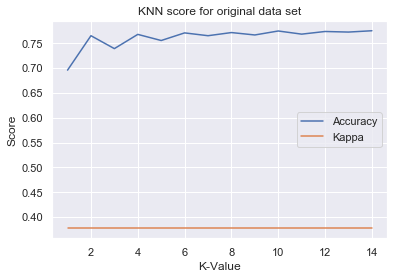

In [479]:
plt.plot(k_range,scores_v0_list)
plt.plot(k_range,kappa_v0_list)
plt.xlabel("K-Value")
plt.ylabel("Score")
plt.legend(["Accuracy","Kappa"])
plt.title("KNN score for original data set")
plt.show()

Kappa is low for this model and data combination. Accuracy is not great either, since it does not do much better than probability for predicting default rate.

In [480]:
#v1 discretized data set
scores_v1 = {}
scores_v1_list = []

kappa_v1 = {}
kappa_v1_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_v1,y_train_v1)
    
    y_pred_v1 = knn.predict(X_test_v1)
    
    scores_v1[k] = metrics.accuracy_score(y_test_v1,y_pred_v1)
    scores_v1_list.append(scores_v1[k])
    
    kappa_v1[k] = metrics.cohen_kappa_score(y_test_v1,y_pred_v1)
    kappa_v1_list.append(kappa_v1[k])

In [481]:
print(scores_v1)
print(kappa_v1)

{1: 0.7261666666666666, 2: 0.7891666666666667, 3: 0.7776666666666666, 4: 0.7933333333333333, 5: 0.7955, 6: 0.8003333333333333, 7: 0.7996666666666666, 8: 0.7996666666666666, 9: 0.8033333333333333, 10: 0.8035, 11: 0.8008333333333333, 12: 0.8041666666666667, 13: 0.8048333333333333, 14: 0.8056666666666666}
{1: 0.20713663887703904, 2: 0.19714280153370056, 3: 0.2751162177803016, 4: 0.22439907086344602, 5: 0.2954498039088086, 6: 0.25277946702842624, 7: 0.28930870786035223, 8: 0.24496934127448589, 9: 0.2933566139724956, 10: 0.26124980575694623, 11: 0.2728236026245692, 12: 0.25798377878865075, 13: 0.2820035717920808, 14: 0.2639296267904365}


In [482]:
#find key (k-value) for best accuracy
max_key = max(scores_v1, key=lambda k: scores_v1[k])

print("Best K-value for accuracy:",max_key)
print("Best Accuracy:",max(scores_v1_list))
print("Best Kappa:",kappa_v1[max_key])

Best K-value for accuracy: 14
Best Accuracy: 0.8056666666666666
Best Kappa: 0.2639296267904365


In [484]:
print(cross_val_score(knn_v1, X_train_v1, y_train_v1, cv=5))

[0.80462404 0.79541667 0.803125   0.79291667 0.7966243 ]


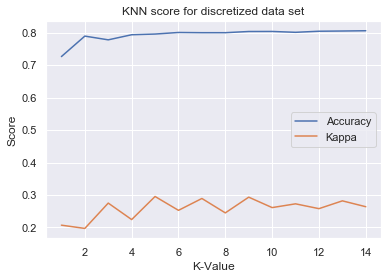

In [483]:
plt.plot(k_range,scores_v1_list)
plt.plot(k_range,kappa_v1_list)
plt.xlabel("K-Value")
plt.ylabel("Score")
plt.legend(["Accuracy","Kappa"])
plt.title("KNN score for discretized data set")
plt.show()

Results not much better here. Let's move on to different models.

In [491]:
#save this classifier as it has highest accuracy for KNN
knn_v1 = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train_v1,y_train_v1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')

#### Random Forest

Metrics: for random forest, let's look at precision and recall as well. For this problem, it is more important to reduce the number of false negatives (a case where someone is incorrectly classified as not a default risk, but does default). False negatives are more impactful to business versus false positive (although this is also harmful, but not as much risk as false negative).

This means we should look at both accuracy and recall as primary metrics. 

In [495]:
#original data
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2,5,10,20]}

# create the grid
grid_RF = GridSearchCV(RandomForestClassifier(n_estimators=10), param_grid, cv = 3, scoring='recall')

#training
grid_RF.fit(X_train_v0, y_train_v0)

#print best estimator
print(grid_RF.best_estimator_)

#with its score
print("Recall:",np.abs(grid_RF.best_score_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall: 0.3522770761576732


In [496]:
rf_v0 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_v0.fit(X_train_v0,y_train_v0)
y_pred_v0 = rf_v0.predict(X_test_v0)

print("Accuracy:",metrics.accuracy_score(y_test_v0, y_pred_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_v0,y_pred_v0))
print("Precision:",metrics.precision_score(y_test_v0,y_pred_v0))
print("Recall:",metrics.recall_score(y_test_v0,y_pred_v0))

Accuracy: 0.8155
Kappa: 0.3630866420800083
Precision: 0.7447495961227787
Recall: 0.32695035460992905


In [497]:
feature_imp = pd.Series(rf_v0.feature_importances_,index=features.columns).sort_values(ascending=False)
feature_imp

PAY_0        0.394100
PAY_4        0.128005
PAY_2        0.113856
PAY_6        0.066027
PAY_5        0.062474
LIMIT_BAL    0.035954
PAY_3        0.035933
PAY_AMT1     0.034779
PAY_AMT2     0.031453
PAY_AMT5     0.016364
PAY_AMT4     0.016134
BILL_AMT5    0.010678
BILL_AMT1    0.009898
BILL_AMT3    0.009453
BILL_AMT6    0.009003
PAY_AMT3     0.008778
BILL_AMT2    0.006474
PAY_AMT6     0.003331
EDUCATION    0.003027
BILL_AMT4    0.003012
AGE          0.001266
MARRIAGE     0.000000
SEX          0.000000
dtype: float64

Payments 1,2,4 have an overwhelming influence on the model. If recall doesn't get much better, may look at modifying dataset to include these variables only.

In [498]:
#discretized (v1) data set

#training
grid_RF.fit(X_train_v1, y_train_v1)

#let's see the best estimator
print(grid_RF.best_estimator_)

#with its F1 score
print("Recall:",np.abs(grid_RF.best_score_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall: 0.32088322320544377


In [500]:
#best estimator/model
rf_v1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_v1.fit(X_train_v1,y_train_v1)
y_pred_v1 = rf_v1.predict(X_test_v1)

print("Accuracy:",metrics.accuracy_score(y_test_v1, y_pred_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_v1,y_pred_v1))
print("Precision:",metrics.precision_score(y_test_v1,y_pred_v1))
print("Recall:",metrics.recall_score(y_test_v1,y_pred_v1))

Accuracy: 0.8126666666666666
Kappa: 0.29745126068120986
Precision: 0.6763005780346821
Recall: 0.2685539403213466


In [501]:
#CORR data set

#training
grid_RF.fit(X_train_CORR, y_train_CORR)

#let's see the best estimator
print(grid_RF.best_estimator_)

#with its F1 score
print("Recall:",np.abs(grid_RF.best_score_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall: 0.3544050713310145


In [502]:
#best estimator/model
rf_CORR = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_CORR.fit(X_train_CORR,y_train_CORR)
y_pred_CORR = rf_CORR.predict(X_test_CORR)

print("Accuracy:",metrics.accuracy_score(y_test_CORR, y_pred_CORR))
print("Kappa:",metrics.cohen_kappa_score(y_test_CORR,y_pred_CORR))
print("Precision:",metrics.precision_score(y_test_CORR,y_pred_CORR))
print("Recall:",metrics.recall_score(y_test_CORR,y_pred_CORR))

Accuracy: 0.8213333333333334
Kappa: 0.3811479897219766
Precision: 0.6858345021037868
Recall: 0.36574420344053854


In [173]:
#modify to increase max_depth
rf_CORR_2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_CORR_2.fit(X_train_CORR,y_train_CORR)
y_pred_2_CORR = rf_CORR_2.predict(X_test_CORR)

print("Accuracy:",metrics.accuracy_score(y_test_CORR, y_pred_2_CORR))
print("Kappa:",metrics.cohen_kappa_score(y_test_CORR,y_pred_2_CORR))
print("Precision:",metrics.precision_score(y_test_CORR,y_pred_2_CORR))
print("Recall:",metrics.recall_score(y_test_CORR,y_pred_2_CORR))

Accuracy: 0.8196666666666667
Kappa: 0.37057880572466906
Precision: 0.6742532005689901
Recall: 0.3571966842501884


In [220]:
feature_imp = pd.Series(rf_CORR_2.feature_importances_,index=features_CORR.columns).sort_values(ascending=False)
feature_imp

PAY_0                 0.219198
PAY_2                 0.158947
PAY_5                 0.114511
PAY_3                 0.100379
PAY_4                 0.066019
BILL_AMT1             0.056128
PAY_AMT1              0.051890
LIMIT_BAL             0.046418
PAY_AMT3              0.040192
PAY_AMT2              0.032857
PAY_AMT4              0.031087
PAY_AMT6              0.026545
PAY_AMT5              0.017745
PAY_6                 0.016109
EDUCATION             0.004735
MARRIAGE              0.004675
AGE_(28.0, 34.0]      0.003320
SEX                   0.003304
AGE_(41.0, 79.0]      0.002865
AGE_(20.999, 28.0]    0.002725
AGE_(34.0, 41.0]      0.000351
dtype: float64

Let's test a new data set using PAY_0, PAY_2, PAY_5 and PAY_3 only

In [222]:
credit_varimp = credit[['PAY_0','PAY_2','PAY_3','PAY_5']]

In [223]:
X_train_varimp, X_test_varimp, y_train_varimp, y_test_varimp = train_test_split(credit_varimp, y, test_size=0.2)

In [224]:
X_train_varimp.shape, X_test_varimp.shape, y_train_varimp.shape, y_test_varimp.shape

((24000, 4), (6000, 4), (24000,), (6000,))

In [226]:
rf_varimp = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_varimp.fit(X_train_varimp,y_train_varimp)
y_pred_varimp = rf_varimp.predict(X_test_varimp)

print("Accuracy:",metrics.accuracy_score(y_test_varimp, y_pred_varimp))
print("Kappa:",metrics.cohen_kappa_score(y_test_varimp,y_pred_varimp))
print("Precision:",metrics.precision_score(y_test_varimp,y_pred_varimp))
print("Recall:",metrics.recall_score(y_test_varimp,y_pred_varimp))

Accuracy: 0.819
Kappa: 0.37895977477856146
Precision: 0.6790123456790124
Recall: 0.3674832962138085


Not much improvement.

In [503]:
#RFE data set

#training
grid_RF.fit(X_train_RFE, y_train_RFE)

#let's see the best estimator
print(grid_RF.best_estimator_)

#with its F1 score
print("Recall:",np.abs(grid_RF.best_score_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall: 0.3350637035669899


In [504]:
#best estimator/model
rf_RFE = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_RFE.fit(X_train_RFE,y_train_RFE)
y_pred_RFE = rf_RFE.predict(X_test_RFE)

print("Accuracy:",metrics.accuracy_score(y_test_RFE, y_pred_RFE))
print("Kappa:",metrics.cohen_kappa_score(y_test_RFE,y_pred_RFE))
print("Precision:",metrics.precision_score(y_test_RFE,y_pred_RFE))
print("Recall:",metrics.recall_score(y_test_RFE,y_pred_RFE))

Accuracy: 0.8268333333333333
Kappa: 0.35454051857916913
Precision: 0.6699029126213593
Recall: 0.33146517213771015


#### Decision Tree

In [507]:
#original data set

#use same grid as RF classifier

# create the grid
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 3, scoring='recall')

#training
grid_tree.fit(X_train_v0, y_train_v0)

#print best estimator
print(grid_tree.best_estimator_)

#with its score
print("Recall:",np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Recall: 0.3666283964791427


In [509]:
tree_v0 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

tree_v0.fit(X_train_v0,y_train_v0)
y_pred_v0 = tree_v0.predict(X_test_v0)


print("Accuracy:",metrics.accuracy_score(y_test_v0, y_pred_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_v0,y_pred_v0))
print("Precision:",metrics.precision_score(y_test_v0,y_pred_v0))
print("Recall:",metrics.recall_score(y_test_v0,y_pred_v0))

Accuracy: 0.815
Kappa: 0.3771253493148379
Precision: 0.7136752136752137
Recall: 0.3553191489361702


In [510]:
#discretized data set

#use same grid as RF classifier

# create the grid
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 3, scoring='recall')

#training
grid_tree.fit(X_train_v1, y_train_v1)

#print best estimator
print(grid_tree.best_estimator_)

#with its score
print("Recall:",np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Recall: 0.35954001841863675


In [174]:
tree_v1 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

tree_v1.fit(X_train_v1,y_train_v1)
y_pred_treev1 = tree_v1.predict(X_test_v1)

print("Accuracy:",metrics.accuracy_score(y_test_v1, y_pred_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_v1,y_pred_v1))
print("Precision:",metrics.precision_score(y_test_v1,y_pred_v1))
print("Recall:",metrics.recall_score(y_test_v1,y_pred_v1))

Accuracy: 0.8223333333333334
Kappa: 0.3754808875279745
Precision: 0.6690140845070423
Recall: 0.36370597243491576


In [512]:
#CORR data set
#training
grid_tree.fit(X_train_CORR, y_train_CORR)

#print best estimator
print(grid_tree.best_estimator_)

#with its score
print("Recall:",np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Recall: 0.36988109605540354


In [513]:
tree_CORR = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

tree_CORR.fit(X_train_CORR,y_train_CORR)
y_pred_CORR = tree_CORR.predict(X_test_CORR)

print("Accuracy:",metrics.accuracy_score(y_test_CORR, y_pred_CORR))
print("Kappa:",metrics.cohen_kappa_score(y_test_CORR,y_pred_CORR))
print("Precision:",metrics.precision_score(y_test_CORR,y_pred_CORR))
print("Recall:",metrics.recall_score(y_test_CORR,y_pred_CORR))

Accuracy: 0.818
Kappa: 0.3597679842951633
Precision: 0.6842105263157895
Recall: 0.3403141361256545


Not worth more analysis; decision trees perform very similary to RF.

#### Support Vector Machine

In [168]:
#original data set

#create new grid for SVM - took too long to run
'''param_grid_SVM = {'C': [0.1,1,10],
                  'kernel': ['linear','rbf'],
                  'gamma': [1,0.1,0.001]}

# create the grid
grid_SVM = dcv.GridSearchCV(SVC(), param_grid_SVM, cv = 3, scoring='recall', n_jobs=-1)

#training        
grid_SVM.fit(X_train_v0, y_train_v0)

#print best estimator
print(grid_SVM.best_estimator_)

#with its score
print("Recall:",np.abs(grid_SVM.best_score_))'''

KeyboardInterrupt: 

In [137]:
SVM = SVC(gamma='auto')

SVM.fit(X_train_v0,y_train_v0)

y_pred_v0 = SVM.predict(X_test_v0)

print("Accuracy:",metrics.accuracy_score(y_test_v0, y_pred_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_v0,y_pred_v0))
print("Precision:",metrics.precision_score(y_test_v0,y_pred_v0))
print("Recall:",metrics.recall_score(y_test_v0,y_pred_v0))

Accuracy: 0.7806666666666666
Kappa: 0.012317264308953746
Precision: 0.4838709677419355
Recall: 0.011406844106463879


In [138]:
#discretized data set
SVM.fit(X_train_v1,y_train_v1)

y_pred_v1 = SVM.predict(X_test_v1)

print("Accuracy:",metrics.accuracy_score(y_test_v1, y_pred_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_v1,y_pred_v1))
print("Precision:",metrics.precision_score(y_test_v1,y_pred_v1))
print("Recall:",metrics.recall_score(y_test_v1,y_pred_v1))

Accuracy: 0.8115
Kappa: 0.3025616317221198
Precision: 0.6565295169946332
Recall: 0.28101071975497705


In [139]:
#CORR data set
SVM.fit(X_train_CORR,y_train_CORR)

y_pred_CORR = SVM.predict(X_test_CORR)

print("Accuracy:",metrics.accuracy_score(y_test_CORR, y_pred_CORR))
print("Kappa:",metrics.cohen_kappa_score(y_test_CORR,y_pred_CORR))
print("Precision:",metrics.precision_score(y_test_CORR,y_pred_CORR))
print("Recall:",metrics.recall_score(y_test_CORR,y_pred_CORR))

Accuracy: 0.7805
Kappa: 0.023943160932034302
Precision: 0.625
Recall: 0.018839487565938208


In [140]:
#RFE data set
SVM.fit(X_train_RFE,y_train_RFE)

y_pred_RFE = SVM.predict(X_test_RFE)

print("Accuracy:",metrics.accuracy_score(y_test_RFE, y_pred_RFE))
print("Kappa:",metrics.cohen_kappa_score(y_test_RFE,y_pred_RFE))
print("Precision:",metrics.precision_score(y_test_RFE,y_pred_RFE))
print("Recall:",metrics.recall_score(y_test_RFE,y_pred_RFE))

Accuracy: 0.7881666666666667
Kappa: 0.018191649607972038
Precision: 0.5588235294117647
Recall: 0.014901960784313726


#### Logistic Regression

In [142]:
#original data set
log = LogisticRegression(solver='liblinear')
log.fit(X_train_v0,y_train_v0)
y_pred_v0 = log.predict(X_test_v0)

print("Accuracy:",metrics.accuracy_score(y_test_v0, y_pred_v0))
print("Recall:", metrics.recall_score(y_test_v0,y_pred_v0))

Accuracy: 0.7808333333333334
Recall: 0.0


In [143]:
#discretized data set
log.fit(X_train_v1,y_train_v1)
y_pred_log_v1 = log.predict(X_test_v1)

print("Accuracy:",metrics.accuracy_score(y_test_v1, y_pred_log_v1))
print("Recall:",metrics.recall_score(y_test_v1,y_pred_log_v1))

Accuracy: 0.7823333333333333
Recall: 0.0


#### Gradient Boosted

In [148]:
#set parameters for GBM
param_grid_GBM = {'n_estimators': [100,200,300],
                  'loss': ['deviance','exponential']}

# create the grid
grid_GBM = dcv.GridSearchCV(GradientBoostingClassifier(), param_grid_GBM, cv = 3, scoring='recall')

#training        
grid_GBM.fit(X_train_v0, y_train_v0)

#print best estimator
print(grid_GBM.best_estimator_)

#with its score
print("Recall:",np.abs(grid_GBM.best_score_))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall: 0.37023111730076586


In [172]:
GBM_v0 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GBM_v0.fit(X_train_v0,y_train_v0)
y_pred_GBMv0 = GBM_v0.predict(X_test_v0)


print("Accuracy:",metrics.accuracy_score(y_test_v0, y_pred_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_v0,y_pred_v0))
print("Precision:",metrics.precision_score(y_test_v0,y_pred_v0))
print("Recall:",metrics.recall_score(y_test_v0,y_pred_v0))

Accuracy: 0.7025
Kappa: 0.04541711083144084
Precision: 0.26214574898785425
Recall: 0.19695817490494297


In [150]:
#training        
grid_GBM.fit(X_train_v1, y_train_v1)

#print best estimator
print(grid_GBM.best_estimator_)

#with its score
print("Recall:",np.abs(grid_GBM.best_score_))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall: 0.37523433955110846


In [162]:
GBM_v1 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GBM_v1.fit(X_train_v1,y_train_v1)
y_pred_v1 = GBM_v1.predict(X_test_v1)

print("Accuracy:",metrics.accuracy_score(y_test_v1, y_pred_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_v1,y_pred_v1))
print("Precision:",metrics.precision_score(y_test_v1,y_pred_v1))
print("Recall:",metrics.recall_score(y_test_v1,y_pred_v1))

Accuracy: 0.8223333333333334
Kappa: 0.3754808875279745
Precision: 0.6690140845070423
Recall: 0.36370597243491576


In [163]:
#training        
grid_GBM.fit(X_train_CORR, y_train_CORR)

#print best estimator
print(grid_GBM.best_estimator_)

#with its score
print("Recall:",np.abs(grid_GBM.best_score_))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall: 0.3678650017991375


In [165]:
GBM_CORR = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GBM_CORR.fit(X_train_CORR,y_train_CORR)
y_pred_CORR = GBM_CORR.predict(X_test_CORR)

print("Accuracy:",metrics.accuracy_score(y_test_CORR, y_pred_CORR))
print("Kappa:",metrics.cohen_kappa_score(y_test_CORR,y_pred_CORR))
print("Precision:",metrics.precision_score(y_test_CORR,y_pred_CORR))
print("Recall:",metrics.recall_score(y_test_CORR,y_pred_CORR))

Accuracy: 0.8215
Kappa: 0.38750860690519706
Precision: 0.6693121693121693
Recall: 0.3813112283345893


In [166]:
#training        
grid_GBM.fit(X_train_RFE, y_train_RFE)

#print best estimator
print(grid_GBM.best_estimator_)

#with its score
print("Recall:",np.abs(grid_GBM.best_score_))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall: 0.3497481813094572


In [167]:
GBM_RFE = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GBM_RFE.fit(X_train_RFE,y_train_RFE)
y_pred_RFE = GBM_RFE.predict(X_test_RFE)

print("Accuracy:",metrics.accuracy_score(y_test_RFE, y_pred_RFE))
print("Kappa:",metrics.cohen_kappa_score(y_test_RFE,y_pred_RFE))
print("Precision:",metrics.precision_score(y_test_RFE,y_pred_RFE))
print("Recall:",metrics.recall_score(y_test_RFE,y_pred_RFE))

Accuracy: 0.8245
Kappa: 0.37184955409073284
Precision: 0.6590257879656161
Recall: 0.3607843137254902


#### Neural Network

In [156]:
#original data set
MLP = MLPClassifier(solver='lbfgs')
MLP.fit(X_train_v0,y_train_v0)
y_pred_v0 = MLP.predict(X_test_v0)

print("Accuracy:",metrics.accuracy_score(y_test_v0, y_pred_v0))
print("Recall:", metrics.recall_score(y_test_v0,y_pred_v0))

Accuracy: 0.7025
Recall: 0.19695817490494297


Best performing models in terms of accuracy and recall:<br><br>
RandomForest with CORR data set (rf_CORR_2; y_pred_2_CORR)<br>
DecisionTree with v1 data set (tree_v1; y_pred_v1)<br>
GBM with original data set (GBM_v0; y_pred_GBMv0)

### Compare Models

In [194]:
RF_cm = confusion_matrix(y_test_CORR,y_pred_2_CORR)
tree_cm = confusion_matrix(y_test_v1,y_pred_treev1)
GBM_cm = confusion_matrix(y_test_v0,y_pred_GBMv0)

In [195]:
RF_cm

array([[4444,  229],
       [ 853,  474]], dtype=int64)

In [213]:
#print RF metrics again
print("Accuracy:",metrics.accuracy_score(y_test_CORR, y_pred_2_CORR))
print("Kappa:",metrics.cohen_kappa_score(y_test_CORR,y_pred_2_CORR))
print("Precision:",metrics.precision_score(y_test_CORR,y_pred_2_CORR))
print("Recall:",metrics.recall_score(y_test_CORR,y_pred_2_CORR))

Accuracy: 0.8196666666666667
Kappa: 0.37057880572466906
Precision: 0.6742532005689901
Recall: 0.3571966842501884


[Text(0, 0.5, 'Not Default'), Text(0, 1.5, 'Default')]

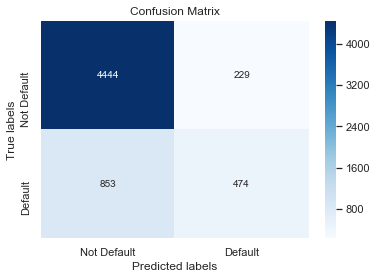

In [215]:
ax = plt.subplot()
sns.heatmap(RF_cm, annot=True, ax = ax, fmt='g', cmap='Blues') #annot=True to annotate cells, fmt='g' to remove sci notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Random Forest')
ax.xaxis.set_ticklabels(['Not Default', 'Default'])
ax.yaxis.set_ticklabels(['Not Default', 'Default'])

[Text(0, 0.5, 'Not Default'), Text(0, 1.5, 'Default')]

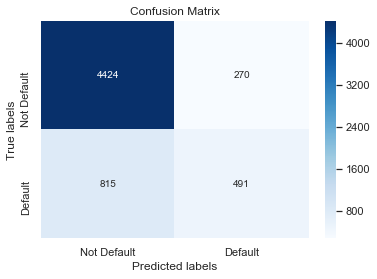

In [216]:
#plot CM for Decision Tree data
ax = plt.subplot()
sns.heatmap(tree_cm, annot=True, ax = ax, fmt='g', cmap='Blues') #annot=True to annotate cells, fmt='g' to remove sci notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Decision Tree')
ax.xaxis.set_ticklabels(['Not Default', 'Default'])
ax.yaxis.set_ticklabels(['Not Default', 'Default'])

In [1]:
#plot CM for GBM model
ax = plt.subplot()
sns.heatmap(GBM_cm, annot=True, ax = ax, fmt='g', cmap='Blues') #annot=True to annotate cells, fmt='g' to remove sci notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for GBM')
ax.xaxis.set_ticklabels(['Not Default', 'Default'])
ax.yaxis.set_ticklabels(['Not Default', 'Default'])

NameError: name 'plt' is not defined

All three models perform pretty similarly with regards to accuracy, precision, and recall. None are all that great for what we need, however. Let's go back and increase cv to 10 to see if there's any improvement.

In [232]:
print("RF with 10-fold CV:",cross_val_score(rf_CORR_2,X_train_CORR,y_train_CORR, cv=10))
print("Decision Tree with 10-fold CV:",cross_val_score(tree_v1,X_train_v1,y_train_v1, cv=10))
print("GBM with 10-fold CV:",cross_val_score(GBM_v0,X_train_v0,y_train_v0, cv=10))

RF with 10-fold CV: [0.82507289 0.82458333 0.82       0.8225     0.81333333 0.81875
 0.81       0.81208333 0.82375    0.82451021]
Decision Tree with 10-fold CV: [0.81875    0.82       0.8225     0.81166667 0.82125    0.815
 0.82708333 0.81958333 0.815      0.82375   ]
GBM with 10-fold CV: [0.82299042 0.81458333 0.81875    0.82166667 0.81       0.815
 0.82916667 0.81791667 0.82041667 0.81533972]


Since none of the models differ all that much in their metrics, even with datasets that are significantly different in terms of feature engineering, conclude that these are the best results we can get with the available data.